In [ ]:
# install a library to work with docx files
# pip install python-docx

In [1]:
# Import Python libraries and helper functions (in utils) 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import numpy as np
import pandas as pd
import string
from collections import Counter
from utils import softmax, relu, get_batches, compute_pca, get_dict, cosine_similarity, euclidean_distance
import re #  Load the Regex-modul


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [3]:
path = './data/almizan_processed.txt'
def get_text(path):
    data = []
    with open('./data/almizan_processed.txt', 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

In [4]:
# tokenize and process the data
def tokenize(corpus):
    data = "\n".join(corpus)
    data = nltk.word_tokenize(data) 
    return data


In [5]:
data = get_text(path)
data = tokenize(data)
# data = stemming(data)
print("Number of tokens:", len(data),'\n', data[:30]) #  print data sample

Number of tokens: 155735 
 ['بسم', 'الله', 'الرحمن', 'الرحيم', 'پايگاه', 'قرآن', 'شناسي', 'حوزه', 'علميه', 'ميبد', 'تفسير', 'الميزان', 'السيد', 'الطباطبائي', 'الجز', 'الثاني', 'سورة', 'البقرة', 'يأيها', 'الذين', 'امنوا', 'كتب', 'عليكم', 'الصيام', 'كما', 'كتب', 'على', 'الذين', 'من', 'قبلكم']


In [6]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ", len(fdist))
print("Most frequent tokens: ", fdist.most_common(20)) # print the 20 most frequent words and their freq.

Size of vocabulary:  20449
Most frequent tokens:  [('و', 16135), ('في', 4297), ('من', 4240), ('الله', 2444), ('أن', 2262), ('لا', 2157), ('على', 2145), ('.', 2046), ('ما', 1815), ('تعالى', 1806), ('عن', 1445), ('إلى', 1381), ('قوله', 1292), ('هو', 1224), ('عليه', 1089), ('قال', 1060), ('ذلك', 850), ('كان', 831), ('أو', 736), ('إن', 720)]


In [7]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  20449


In [8]:
# example of word to index mapping
# replace هذا with 'this' because of nice format otherwise we have an ugly format
print(f"Index of the word 'way' :  {word2Ind['صراط']}")
print(f"Word which has index 12578:  {Ind2word[12083]}")

Index of the word 'way' :  12083
Word which has index 12578:  صراط


# Training the Model

In [12]:
def initialize_model(N,V, random_seed=9):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)
    # W1_1 has shape (N,V)
    W1_1 = np.random.rand(N,V)
    
    # W1_2 has shape (N,V)
    W1_2 = np.random.rand(N,V)
    
    # W1_3 has shape (N,V)
    W1_3 = np.random.rand(N,V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    return W1_1, W1_2, W1_3, W2, b1, b2

In [99]:
# Test initialize_model function.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [18]:
def forward_prop(x, W1_1, W1_2, W1_3, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Calculate h
    h1 = np.dot(W1_1, x) + b1
    h2 = np.dot(W1_2, x) + b1
    h3 = np.dot(W1_3, x) + b1
    
    # Apply the relu on h, 
    # store the relu in h
    h1 = relu(h1)
    h2 = relu(h2)
    h3 = relu(h3)
    
    # Calculate z
    z = np.dot(W2, h1) + np.dot(W2, h2)+ np.dot(W2, h3) + b2

    return z, h1, h2, h3

In [101]:
# Test the forward_prop function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [14]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = -1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [103]:
# Test the compute_cost function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (20449, 4)
tmp_y.shape (20449, 4)
tmp_W1.shape (50, 20449)
tmp_W2.shape (20449, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (20449, 1)
tmp_z.shape: (20449, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (20449, 4)
call compute_cost
tmp_cost 13.4959


In [15]:
def back_prop(x, yhat, y, h1, h2, h3, W1_1, W1_2, W1_3, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    # Compute l1 as W2^T (Yhat - Y)
    l1 = np.dot(W2.T, yhat - y)

    # Apply relu to l1
    l1 = relu(l1)

    # compute the gradient for W1_1
    grad_W1_1 = (1/batch_size) * np.dot(l1, x.T)
    
    # compute the gradient for W1_2
    grad_W1_2 = (1/batch_size) * np.dot(l1, x.T)
    
    # compute the gradient for W1_3
    grad_W1_3 = (1/batch_size) * np.dot(l1, x.T)

    # Compute gradient of W2
    grad_W2 = (1/batch_size) * np.dot(yhat - y, h1.T + h2.T + h2.T)
    
    # compute gradient for b1
    grad_b1 = (1/batch_size) * np.sum(l1, axis=1, keepdims=True)

    # compute gradient for b2
    grad_b2 = (1/batch_size) * np.sum((yhat - y), axis=1, keepdims=True)
    
    return grad_W1_1, grad_W1_2, grad_W1_3, grad_W2, grad_b1, grad_b2

In [105]:
# Test the back_prop function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (20449, 4)
tmp_y.shape (20449, 4)

Initialize weights and biases
tmp_W1.shape (50, 20449)
tmp_W2.shape (20449, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (20449, 1)

Forwad prop to get z and h
tmp_z.shape: (20449, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (20449, 4)

call back_prop
tmp_grad_W1.shape (50, 20449)
tmp_grad_W2.shape (20449, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (20449, 1)


In [44]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=9, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: implementation of the function to perform forward propagation
        softmax: implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1_1, W1_2, W1_3, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

#     batch_size = 512
    batch_size = 2048
    iters = 0
    C = 10
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # get z and h
        z, h1, h2, h3 = forward_prop(x, W1_1, W1_2, W1_3, W2, b1, b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 5 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f} --- alpha: {alpha}")
            
        # get gradients
        grad_W1_1, grad_W1_2, grad_W1_3, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h1, h2, h3, W1_1, W1_2, W1_3, W2, b1, b2, batch_size)
        
        # update weights and biases
        W1_1 = W1_1 - alpha * grad_W1_1
        W1_2 = W1_2 - alpha * grad_W1_2
        W1_3 = W1_3 - alpha * grad_W1_3
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        iters +=1 
        if iters == num_iters: 
            break
        if iters % 50 == 0:
            alpha *= 0.75**np.floor(iters/50)
          
            
    return W1_1, W1_2, W1_3, W2, b1, b2

In [20]:
# test gradient_descent function
data = get_text(path)
data = tokenize(data)
# C = 4
# batch_size = 1024
# alpha = 0.03
N = 300
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1_1, W1_2, W1_3, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 101.375138 --- alpha: 0.03
iters: 20 cost: 69.733171 --- alpha: 0.03
iters: 30 cost: 62.011337 --- alpha: 0.03
iters: 40 cost: 40.096269 --- alpha: 0.03
iters: 50 cost: 74.260180 --- alpha: 0.03
iters: 60 cost: 48.492908 --- alpha: 0.03
iters: 70 cost: 30.582832 --- alpha: 0.03
iters: 80 cost: 17.727734 --- alpha: 0.03
iters: 90 cost: 24.935919 --- alpha: 0.03
iters: 100 cost: 26.309843 --- alpha: 0.03
iters: 110 cost: 22.834521 --- alpha: 0.0198
iters: 120 cost: 5.648274 --- alpha: 0.0198
iters: 130 cost: 15.566277 --- alpha: 0.0198
iters: 140 cost: 19.370512 --- alpha: 0.0198
iters: 150 cost: 24.542829 --- alpha: 0.0198
iters: 160 cost: 12.445880 --- alpha: 0.0198
iters: 170 cost: 3.225476 --- alpha: 0.0198
iters: 180 cost: 13.001639 --- alpha: 0.0198
iters: 190 cost: 8.964290 --- alpha: 0.0198
iters: 200 cost: 14.237978 --- alpha: 0.0198
iters: 210 cost: 13.607223 --- alpha: 0.013068000000000001
iters: 220 cost: 8.481114 --- alpha: 0.01306800000

In [24]:
# test gradient_descent function
data = get_text(path)
data = tokenize(data)
# C = 10
# batch_size = 512
# alpha = 0.001
N = 300
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1_1, W1_2, W1_3, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 66.918643 --- alpha: 0.001
iters: 20 cost: 43.267170 --- alpha: 0.001
iters: 30 cost: 29.231779 --- alpha: 0.001
iters: 40 cost: 51.534444 --- alpha: 0.001
iters: 50 cost: 66.261764 --- alpha: 0.001
iters: 60 cost: 40.553645 --- alpha: 0.001
iters: 70 cost: 35.696168 --- alpha: 0.001
iters: 80 cost: 27.725833 --- alpha: 0.001
iters: 90 cost: 50.026515 --- alpha: 0.001
iters: 100 cost: 47.167521 --- alpha: 0.001
iters: 110 cost: 30.696450 --- alpha: 0.00066
iters: 120 cost: 39.898838 --- alpha: 0.00066
iters: 130 cost: 62.846918 --- alpha: 0.00066
iters: 140 cost: 25.971666 --- alpha: 0.00066
iters: 150 cost: 29.949782 --- alpha: 0.00066
iters: 160 cost: 22.250742 --- alpha: 0.00066
iters: 170 cost: 35.600634 --- alpha: 0.00066
iters: 180 cost: 33.964402 --- alpha: 0.00066
iters: 190 cost: 71.404675 --- alpha: 0.00066
iters: 200 cost: 33.275135 --- alpha: 0.00066
iters: 210 cost: 71.874649 --- alpha: 0.0004356
iters: 220 cost: 30.940600 --- alpha: 0

In [39]:
# test gradient_descent function
data = get_text(path)
data = tokenize(data)
# C = 10
# batch_size = 2048
# alpha = 0.001
N = 300
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1_1, W1_2, W1_3, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 5 cost: 41.706129 --- alpha: 0.001
iters: 10 cost: 66.918643 --- alpha: 0.001
iters: 15 cost: 70.892572 --- alpha: 0.00099
iters: 20 cost: 43.278800 --- alpha: 0.00099
iters: 25 cost: 15.232660 --- alpha: 0.0009801
iters: 30 cost: 29.287249 --- alpha: 0.0009801
iters: 35 cost: 37.237419 --- alpha: 0.000970299
iters: 40 cost: 51.578663 --- alpha: 0.000970299
iters: 45 cost: 18.045089 --- alpha: 0.0009605960099999999
iters: 50 cost: 66.325030 --- alpha: 0.0009605960099999999
iters: 55 cost: 33.833182 --- alpha: 0.0009509900498999999
iters: 60 cost: 40.635341 --- alpha: 0.0009509900498999999
iters: 65 cost: 51.619576 --- alpha: 0.0009414801494009999
iters: 70 cost: 35.799551 --- alpha: 0.0009414801494009999
iters: 75 cost: 69.136048 --- alpha: 0.0009320653479069899
iters: 80 cost: 27.894763 --- alpha: 0.0009320653479069899
iters: 85 cost: 40.811603 --- alpha: 0.00092274469442792
iters: 90 cost: 50.164309 --- alpha: 0.00092274469442792
iters: 95 cost: 39.208214

iters: 700 cost: 13.543302 --- alpha: 1.0764959938155194e-30
iters: 705 cost: 42.082482 --- alpha: 1.0657310338773642e-30
iters: 710 cost: 12.208418 --- alpha: 3.1971931016320926e-31
iters: 715 cost: 45.704694 --- alpha: 3.1652211706157717e-31
iters: 720 cost: 2.052140 --- alpha: 3.1652211706157717e-31
iters: 725 cost: 42.325806 --- alpha: 9.400706876728841e-32
iters: 730 cost: 56.692029 --- alpha: 2.8202120630186524e-32
iters: 735 cost: 42.667113 --- alpha: 8.376029827165396e-33
iters: 740 cost: 2.543604 --- alpha: 2.5128089481496186e-33
iters: 745 cost: 18.663498 --- alpha: 2.2389127728013103e-34
iters: 750 cost: 46.152632 --- alpha: 6.716738318403931e-35
iters: 755 cost: 48.726163 --- alpha: 1.9948712805659673e-35
iters: 760 cost: 35.485087 --- alpha: 1.9948712805659673e-35
iters: 765 cost: 25.149945 --- alpha: 1.9749225677603076e-35
iters: 770 cost: 2.345551 --- alpha: 1.9749225677603076e-35
iters: 775 cost: 7.034794 --- alpha: 5.8655200262481134e-36
iters: 780 cost: 42.790278 --- 

In [45]:
# test gradient_descent function
data = get_text(path)
data = tokenize(data)
# C = 10
# batch_size = 512
# alpha = 0.03
N = 300
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1_1, W1_2, W1_3, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 5 cost: 48.713220 --- alpha: 0.03
iters: 10 cost: 105.856746 --- alpha: 0.03
iters: 15 cost: 114.976174 --- alpha: 0.03
iters: 20 cost: 45.294302 --- alpha: 0.03
iters: 25 cost: 34.625680 --- alpha: 0.03
iters: 30 cost: 58.594012 --- alpha: 0.03
iters: 35 cost: 49.256010 --- alpha: 0.03
iters: 40 cost: 41.570173 --- alpha: 0.03
iters: 45 cost: 24.658628 --- alpha: 0.03
iters: 50 cost: 52.937060 --- alpha: 0.03
iters: 55 cost: 22.890490 --- alpha: 0.0225
iters: 60 cost: 25.514921 --- alpha: 0.0225
iters: 65 cost: 35.952617 --- alpha: 0.0225
iters: 70 cost: 41.748288 --- alpha: 0.0225
iters: 75 cost: 55.671922 --- alpha: 0.0225
iters: 80 cost: 35.890737 --- alpha: 0.0225
iters: 85 cost: 39.034263 --- alpha: 0.0225
iters: 90 cost: 27.163401 --- alpha: 0.0225
iters: 95 cost: 36.001190 --- alpha: 0.0225
iters: 100 cost: 39.690770 --- alpha: 0.0225
iters: 105 cost: 7.271681 --- alpha: 0.012656249999999999
iters: 110 cost: 16.306599 --- alpha: 0.012656249999999999

iters: 725 cost: 3.996875 --- alpha: 2.283252337053825e-15
iters: 730 cost: 27.337592 --- alpha: 2.283252337053825e-15
iters: 735 cost: 21.865791 --- alpha: 2.283252337053825e-15
iters: 740 cost: 3.557248 --- alpha: 2.283252337053825e-15
iters: 745 cost: 6.882426 --- alpha: 2.283252337053825e-15
iters: 750 cost: 19.710362 --- alpha: 2.283252337053825e-15
iters: 755 cost: 26.153078 --- alpha: 3.0512153582571067e-17
iters: 760 cost: 12.947917 --- alpha: 3.0512153582571067e-17
iters: 765 cost: 13.579364 --- alpha: 3.0512153582571067e-17
iters: 770 cost: 2.753292 --- alpha: 3.0512153582571067e-17
iters: 775 cost: 4.913604 --- alpha: 3.0512153582571067e-17
iters: 780 cost: 4.280865 --- alpha: 3.0512153582571067e-17
iters: 785 cost: 7.716035 --- alpha: 3.0512153582571067e-17
iters: 790 cost: 15.948627 --- alpha: 3.0512153582571067e-17
iters: 795 cost: 2.664316 --- alpha: 3.0512153582571067e-17
iters: 800 cost: 19.052697 --- alpha: 3.0512153582571067e-17
iters: 805 cost: 4.947214 --- alpha: 3

In [25]:
# To extract word vectors we have three approaches
# First approach: to assume W1 as word vectors 
# embs = W1.T

# Second approach: to assume W2 as word vectors 
# embs = W2

# Third approach: or to assume the mean of W1+W2 as word vectors 
embs = (W1_1.T + W1_2.T + W1_3.T + W2)/2.0

word_embeddings = {}
for i, vec in enumerate(embs):
    word_embeddings[Ind2word[i]] = vec

# Visualizing the word vectors

In [ ]:
# download 2 libraries for dispalying arabic text on a plot properly
# pip install python-bidi

In [ ]:
# pip install --upgrade arabic-reshaper

In [26]:
# visualizing the word vectors here
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import arabic_reshaper

%config InlineBackend.figure_format = 'svg'
words = ['قال', 'صراط','الآية','المستقيم', 'هذا','سياق','واحدة',
         'التسهيل','التخفيف','معدودة']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 300) [14368, 12083, 2181, 5819, 18371, 11727, 18445, 3142, 3086, 17326]


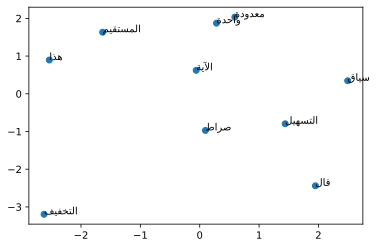

In [33]:
result= compute_pca(X, 2)
plt.scatter(result[:, 1], result[:, 0])
for i, word in enumerate(words):
    reshaped_text = arabic_reshaper.reshape(word)
    artext = get_display(reshaped_text)
    plt.annotate(artext, xy=(result[i, 1], result[i, 0]))
plt.show()

# Evaluation of word vectors

In [128]:
# get vectors
v = word_embeddings[st.stem('صراط')]
w = word_embeddings[st.stem('مستقيم')]

from numpy import linalg

# Calculate Euclidean distance d
d = linalg.norm(v-w)
print("The Euclidean distance between v and w is: ", d)

# Calculate Cosine similarity c
c = np.dot(v,w) / (linalg.norm(v)*linalg.norm(w))
print("The Cosine similarity of v and w is: ", c)

The Euclidean distance between v and w is:  3.4912698182396156
The Cosine similarity of v and w is:  0.8611607861266035


In [131]:
# let's evaluate some word vectors
words = ['كُتِب', 'سياق','المستقيم','التخفيف', 'الْعُسرَ','الكلام','واحدة',
         'التسهيل','صراط','معدودة']
for i, word in enumerate(words):
    words[i] = re.sub('[َُِّءًٌٍْ]', '', word)
    
for i in range(len(words)-1):
    v = word_embeddings[words[i]]
    w = word_embeddings[words[i+1]]
    
    # Calculate Euclidean distance d
    d = linalg.norm(v-w)
    print(f"The Euclidean distance between {words[i]} and {words[i+1]} is: {d}")

    # Calculate Cosine similarity c
    c = np.dot(v,w) / (linalg.norm(v)*linalg.norm(w))
    print(f"The Cosine similarity of {words[i]} and {words[i+1]} is: {c}")
    print()

The Euclidean distance between كتب and سياق is: 3.558455696017064
The Cosine similarity of كتب and سياق is: 0.8640351648414126

The Euclidean distance between سياق and المستقيم is: 3.710402682497853
The Cosine similarity of سياق and المستقيم is: 0.8524622705786361

The Euclidean distance between المستقيم and التخفيف is: 3.3779984065019826
The Cosine similarity of المستقيم and التخفيف is: 0.867442361455463

The Euclidean distance between التخفيف and العسر is: 3.6708305689580185
The Cosine similarity of التخفيف and العسر is: 0.8406901686117716

The Euclidean distance between العسر and الكلام is: 3.5846196137244513
The Cosine similarity of العسر and الكلام is: 0.8521924811011359

The Euclidean distance between الكلام and واحدة is: 3.4463570878503673
The Cosine similarity of الكلام and واحدة is: 0.8628342203548562

The Euclidean distance between واحدة and التسهيل is: 3.25142838716164
The Cosine similarity of واحدة and التسهيل is: 0.8713164277010864

The Euclidean distance between التسهيل a

In [132]:
# Create a dataframe out of the dictionary embedding.
keys = word_embeddings.keys()
df = []
for key in keys:
    df.append(word_embeddings[key])
    
embedding = pd.DataFrame(data=df, index=keys)

In [133]:
embedding.head(10)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
.,0.256152,0.234185,0.262998,0.769146,0.575151,0.536670,0.143765,0.207388,0.575697,0.744846,...,0.287068,0.298029,0.608141,0.729462,0.547149,0.203740,0.316043,0.745769,0.575267,0.274717
..,0.474089,0.346831,0.513005,0.559900,0.750999,0.587764,0.923888,0.778692,0.848825,0.763675,...,0.606575,0.766731,0.628832,0.684303,0.389864,0.367853,0.374912,0.287971,0.241111,0.636665
آباؤهن,0.436706,0.736095,0.778113,0.664454,0.808450,0.532249,0.289360,0.141241,0.541038,0.265466,...,0.515674,0.415341,0.469296,0.177325,0.672946,0.673528,0.329231,0.143210,0.421628,0.274753
آبائكم,0.256323,0.831660,0.451752,0.394158,0.710520,0.494641,0.843486,0.647085,0.156937,0.813070,...,0.513222,0.484164,0.252853,0.562189,0.285567,0.413538,0.517394,0.767319,0.459870,0.389687
آبائه,0.422039,0.185956,0.413670,0.501493,0.689166,0.467530,0.333331,0.248635,0.414872,0.095999,...,0.289146,0.332645,0.130884,0.411165,0.767012,0.253274,0.516087,0.757594,0.476268,0.454022
آبائهم,0.199850,0.775554,0.553713,0.747809,0.395673,0.180786,0.160946,0.727368,0.504805,0.146942,...,0.449376,0.055593,0.459824,0.235720,0.779463,0.712453,0.452862,0.504350,0.383982,0.889707
آباكم,0.365823,0.933367,0.506829,0.613775,0.815193,0.602273,0.404473,0.470927,0.202103,0.648778,...,0.497204,0.102432,0.248199,0.474122,0.370766,0.175028,0.493862,0.249706,0.528680,0.396553
آباه,0.456806,0.354811,0.272195,0.502853,0.510043,0.521157,0.331822,0.239332,0.951119,0.765883,...,0.809065,0.509421,0.367450,0.243268,0.868459,0.793958,0.799260,0.197552,0.074883,0.959256
آباهم,0.298351,0.451349,0.431717,0.396163,0.665032,0.481242,0.620882,0.287674,0.518210,0.141454,...,0.637589,0.291312,0.110229,0.684804,0.420546,0.320643,0.551686,0.945757,0.473454,0.557469
آبية,0.628270,0.578000,0.530663,0.410842,0.483492,0.209774,0.834970,0.484220,0.327754,0.499427,...,0.480194,0.440001,0.626281,0.744639,0.253115,0.752201,0.798904,0.452005,0.371207,0.958580


In [134]:
# Define a function to find K closest words to a vector:
def find_closest_word(word, k, embeddings=word_embeddings):
    
    most_closest_words = []
    word_emb = embeddings[word]
    similar_word = ''
    
    for w in embeddings.keys():
        if word != w:
            # get the word embedding
            w_emb = embeddings[w]
            # calculating cosine similarity
            cur_similarity = cosine_similarity(word_emb, w_emb)
            # store the similar_word as a tuple, which contains the word and the similarity
            similar_word = (w, cur_similarity)
            # append each tuple to list
            most_closest_words.append(similar_word)
    # sort based on more similarity
    most_closest_words.sort(key=lambda y: -y[1])
    return most_closest_words[:k]
    

In [135]:
find_closest_word('موهبة',20)

[('أخذها', 0.9129466934906125),
 ('دخلت', 0.9122681003845605),
 ('حظ', 0.9120120905400518),
 ('تعلل', 0.9106417968383892),
 ('يكنى', 0.9096955789853076),
 ('لدودا', 0.9095126602051142),
 ('فنحرها', 0.9094109808351455),
 ('نوعيهما', 0.9084048791513415),
 ('توطين', 0.9076645041125858),
 ('يشتمل', 0.9072261384088235),
 ('بحجه', 0.9070534915280136),
 ('خطإ', 0.9068875366669401),
 ('يصف', 0.906665619178433),
 ('لأملأن', 0.9065464322414832),
 ('فمخاطب', 0.9060140603715547),
 ('أهللت', 0.9055880200277683),
 ('البشرية', 0.9055833322700126),
 ('مقتدر', 0.9054544869467438),
 ('ديننا', 0.9051923424947835),
 ('اتقوني', 0.9047966017047752)]

In [ ]:
find_closest_word('موهبة',20)

In [136]:
find_closest_word('صراط',20)

[('نازل', 0.9005769064160624),
 ('الكبير', 0.8980941877702578),
 ('لئن', 0.8957831571500747),
 ('قوله', 0.893706924160934),
 ('أجمل', 0.8929070002422238),
 ('الاستتار', 0.8919577192935044),
 ('خطإ', 0.8918843890300903),
 ('يقتله', 0.8916020577106345),
 ('بالذوق', 0.8916001896229667),
 ('للقصاص', 0.8915689690721575),
 ('استقصا', 0.8913619850241247),
 ('مرة', 0.8912172187198889),
 ('الرابعة', 0.8909492933238644),
 ('ألهمها', 0.8908121564841871),
 ('نفارق', 0.8908057777896382),
 ('سيحبط', 0.8906664011440801),
 ('ليخرج', 0.8904644032034429),
 ('تخفيفا', 0.8899437587913325),
 ('المألوفة', 0.8895532412995428),
 ('مادة', 0.889382447462529)]

In [ ]:
find_closest_word('صراط',20)

In [ ]:
# pip install pickle-mixin

In [ ]:
import pickle # to store word embeddings result

In [ ]:
data = {'embeddings': word_embeddings}
with open('embeddings.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
# with open('embeddings.pkl', 'rb') as file:
#     saved_data = pickle.load(file)

# new_embeddings = saved_data['embeddings']